# Train Neural Net
> NN training notebook

### To-do
---
- Early stopping
- Repeats
- Rename `epochs` ---> `max_epochs`
- "Best model" saving after training and selecting best model using some kind of criteria:
```python
import pickle
file_name = '/tmp/mymodel.pkl'
# Save
with open(file_name, 'wb') as f:
    pickle.dump(net, f)
# Load it back when needed
with open(file_name, 'rb') as f:
    new_net = pickle.load(f)
```

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt

import matplotlib
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
# matplotlib.rcParams['font.size']= 22 # use for presentation

In case if you want to use CUDA-enabled GPU

- the for using GPU is not yet complete, but could still work.
- Need to implement mini-batch
- Right now tensors are copied to GPU from the beginning, which won't work for large datasets as we will fill up the GPU memory. But this way is faster as we don't spend time copying the tensors between devices.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cpu


## Training

`nn` module implements these networks (not the same as torch.nn):
- `fcNet` : fully-connected neural network, linear layer as a final layer (a.k.a. linear combiner)
    - e.g. Initialise network with two (hidden) layers, with dimensions `[8, 4]`
    ```python
model = fcNet(input_dim, layer_dims=[8,4], output_dim=1)
Y = model(x)
```
- `diffNet` : difference network. `diffNet(x,Y0) = Y0 + fcNet(x)`
    - e.g. Init. diff. net with 3 hidden layers, with dim-s `[16,8,4]`
    ```python
model = diffNet(input_dim, layer_dims=[16,8,4], output_dim=1)
Y = model(x, Y0)
```

In [ ]:
from torch.nn import MSELoss

In [ ]:
# Neural network implementations: fcNet, diffNet
from src.nnets import fcNet, diffNet, get_model, train_model

### Persistence

In [ ]:
with open('persistence_T5.npy','rb') as f:
    persistence=np.load(f,allow_pickle=True).item()
print('Persistence:',persistence)

Persistence: {'lead_time': 5, 'Persistence_Euclidean': 0.7021652369157633, 'Persistence_MSE': 1.4043304738315265}


### Naive Window

In [ ]:
# Training data
with open('train_preprocessed_naivewin21.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_naivewin21.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([595, 22]) torch.float32,
test: torch.Size([256, 22]) torch.float32


In [ ]:
x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}')

Training x torch.Size([595, 20]), Y0 torch.Size([595, 1]), y torch.Size([595, 1])


In [ ]:
x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}')

x_test torch.Size([256, 20]), Y0_test torch.Size([256, 1]), y_test torch.Size([256, 1])


In [ ]:
# Network size:
input_dim = x.shape[1]
layer_dims = [64,32,16]
dropout_p = [.25] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.4039658308029175, test_loss: 1.385878324508667
epoch 100> train_loss: 1.0519357919692993, test_loss: 1.2997111082077026
epoch 200> train_loss: 0.8741177320480347, test_loss: 1.3683569431304932
epoch 300> train_loss: 0.7851431965827942, test_loss: 1.403822660446167
epoch 400> train_loss: 0.7381415963172913, test_loss: 1.4116995334625244
epoch 500> train_loss: 0.7076839804649353, test_loss: 1.4260191917419434
epoch 600> train_loss: 0.6932156682014465, test_loss: 1.4328852891921997
epoch 700> train_loss: 0.6863952875137329, test_loss: 1.4313305616378784
epoch 800> train_loss: 0.6811601519584656, test_loss: 1.43402099609375
epoch 900> train_loss: 0.6780357956886292, test_loss: 1.4353922605514526


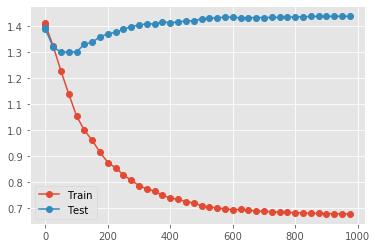

In [ ]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate})

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

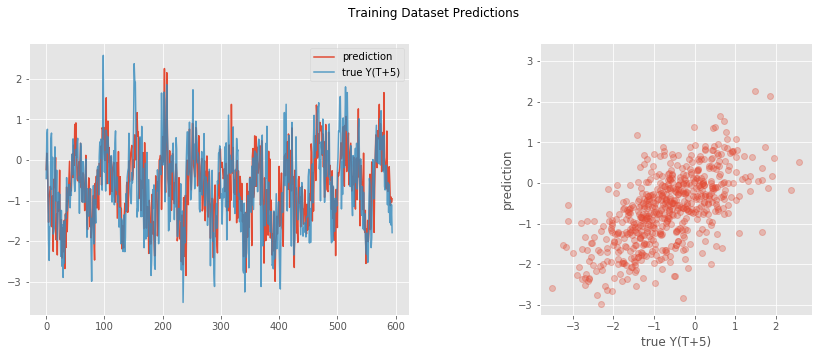

In [ ]:
net.eval()
pred = net(x,Y0).detach().numpy()
target = y.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

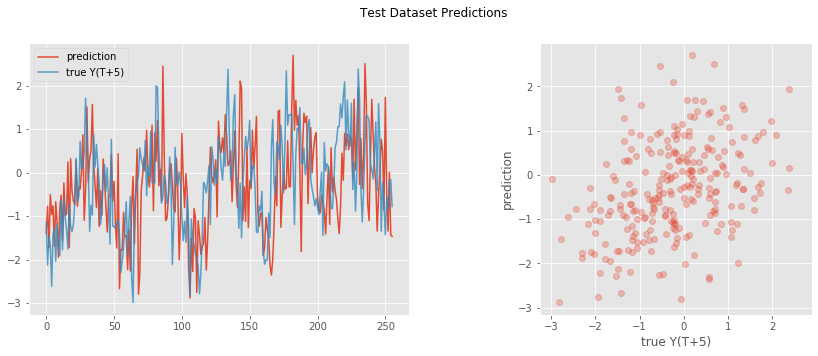

In [ ]:
net.eval()
pred_test = net(x_test,Y0_test).detach().numpy()
target_test = y_test.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

In [ ]:
# another way to calculate/re-calculate MSE loss for the model
from src.utils import mse
mse_loss_with_np = mse(net(x_test,Y0_test).detach().numpy(), y_test.numpy()) # same as MSELoss()'s result
print('MSE loss:',mse_loss_with_np)

MSE loss: 1.4360377


- **Lagged (Cross-) Correlation**

Train lag peak:5
Test lag peak:5


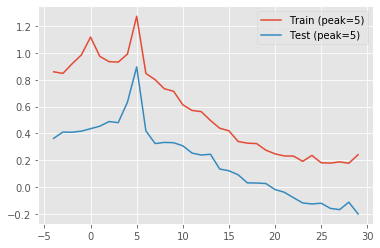

In [ ]:
from src.utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().numpy().ravel(), 
                                        y.numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().numpy().ravel(),
                                      y_test.numpy().ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

plt.legend();
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

### Difference Net

In [ ]:
# Training data
with open('train_preprocessed_diff21.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_diff21.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([595, 22]) torch.float32,
test: torch.Size([256, 22]) torch.float32


In [ ]:
x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)

print(f'Training x {x.shape}')

Training x torch.Size([595, 20])


In [ ]:
x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'Training x_test {x_test.shape}')

Training x_test torch.Size([256, 20])


In [ ]:
# Network size:
input_dim = x.shape[1]
layer_dims = [64,32,16]
dropout_p = [.25] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.4227855205535889, test_loss: 1.4147858619689941
epoch 100> train_loss: 0.8445587754249573, test_loss: 1.167099952697754
epoch 200> train_loss: 0.6887352466583252, test_loss: 1.1810446977615356
epoch 300> train_loss: 0.6177807450294495, test_loss: 1.1764992475509644
epoch 400> train_loss: 0.5795741677284241, test_loss: 1.1824476718902588
epoch 500> train_loss: 0.5606346130371094, test_loss: 1.1870903968811035
epoch 600> train_loss: 0.549467921257019, test_loss: 1.1877466440200806
epoch 700> train_loss: 0.543824315071106, test_loss: 1.1886610984802246
epoch 800> train_loss: 0.5394499897956848, test_loss: 1.189798355102539
epoch 900> train_loss: 0.5374191403388977, test_loss: 1.1899456977844238


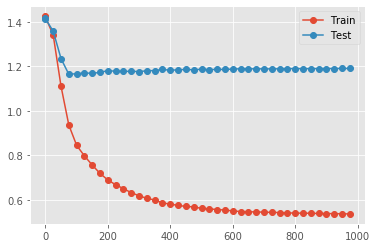

In [ ]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate})

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

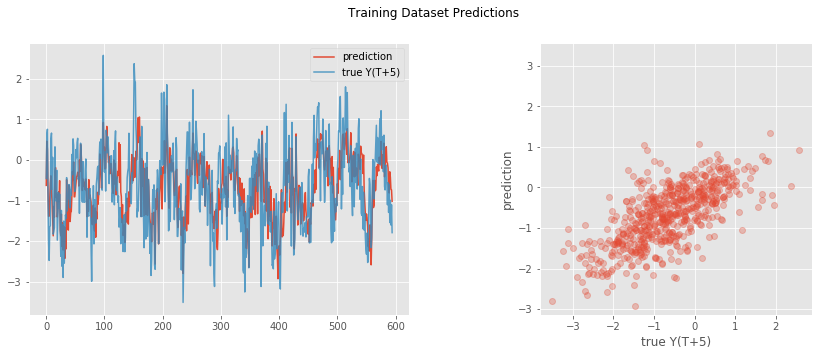

In [ ]:
net.eval()
pred = net(x,Y0).detach().numpy()
target = y.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

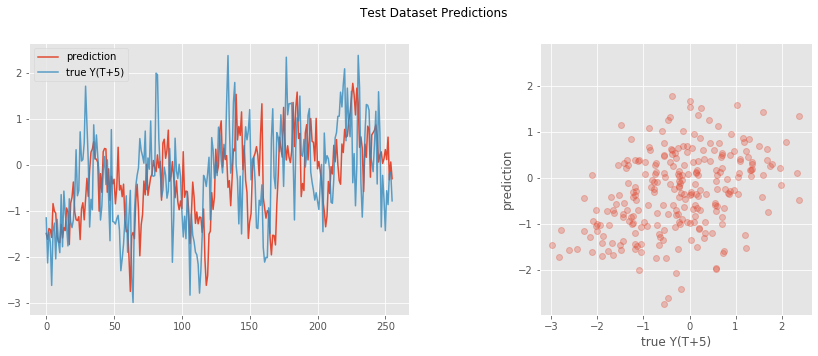

In [ ]:
net.eval()
pred_test = net(x_test,Y0_test).detach().numpy()
target_test = y_test.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

Train lag peak:0
Test lag peak:5


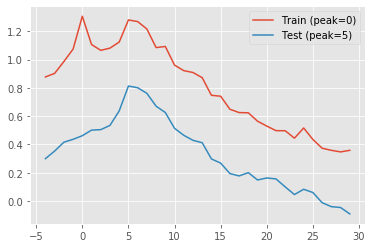

In [ ]:
from src.utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().numpy().ravel(), 
                                        y.numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().numpy().ravel(),
                                      y_test.numpy().ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

plt.legend();
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

### Difference with step size=Lead_time

In [ ]:
# Training data
with open('train_preprocessed_stepdiff21.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_stepdiff21.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([595, 18]) torch.float32,
test: torch.Size([256, 18]) torch.float32


In [ ]:
x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)

print(f'Training x {x.shape}')

Training x torch.Size([595, 16])


In [ ]:
x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'x_test {x_test.shape}')

x_test torch.Size([256, 16])


In [ ]:
# Network size:
input_dim = x.shape[1]
layer_dims = [64,32,16]
dropout_p = [.25] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.4337272644042969, test_loss: 1.4042997360229492
epoch 100> train_loss: 0.9195225238800049, test_loss: 1.114180564880371
epoch 200> train_loss: 0.7995873093605042, test_loss: 1.0790425539016724
epoch 300> train_loss: 0.749748945236206, test_loss: 1.0826400518417358
epoch 400> train_loss: 0.7179623246192932, test_loss: 1.0845365524291992
epoch 500> train_loss: 0.7047123908996582, test_loss: 1.081634521484375
epoch 600> train_loss: 0.6953123807907104, test_loss: 1.0834153890609741
epoch 700> train_loss: 0.6878035664558411, test_loss: 1.083701729774475
epoch 800> train_loss: 0.6865938901901245, test_loss: 1.0831339359283447
epoch 900> train_loss: 0.6844402551651001, test_loss: 1.0833556652069092


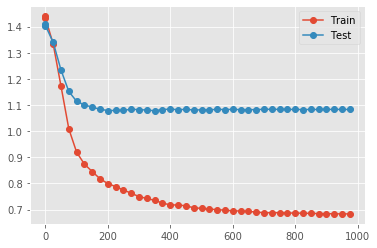

In [ ]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate})

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

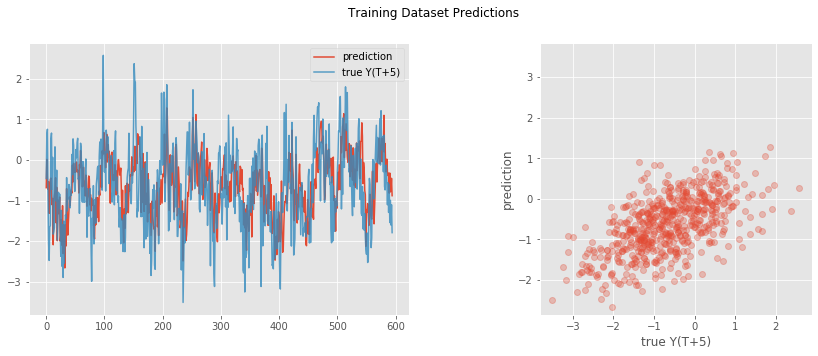

In [ ]:
net.eval()
pred = net(x,Y0).detach().numpy()
target = y.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

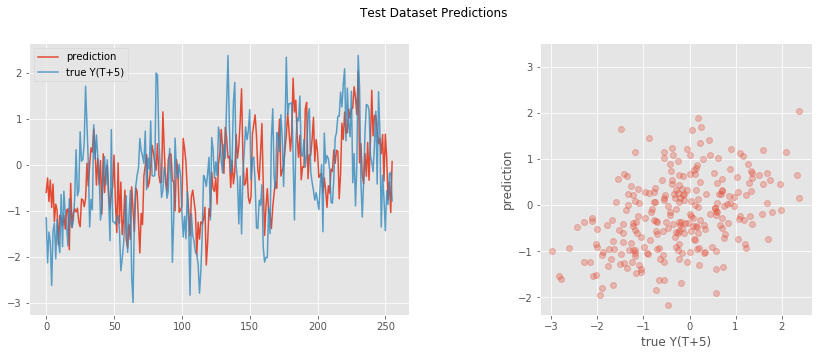

In [ ]:
net.eval()
pred_test = net(x_test,Y0_test).detach().numpy()
target_test = y_test.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

Train lag peak:5
Test lag peak:5


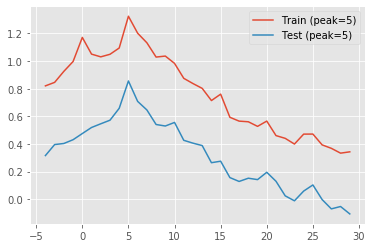

In [ ]:
from src.utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().numpy().ravel(), 
                                        y.numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().numpy().ravel(),
                                      y_test.numpy().ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

plt.legend();
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

### Momentum and Force

In [ ]:
# Training data
with open('train_preprocessed_mntfrcwin21.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_mntfrcwin21.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([595, 35]) torch.float32,
test: torch.Size([256, 35]) torch.float32


In [ ]:
x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)

print(f'Training x {x.shape}')

Training x torch.Size([595, 33])


In [ ]:
x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'x_test {x_test.shape}')

x_test torch.Size([256, 33])


In [ ]:
# Network size:
input_dim = x.shape[1]
layer_dims = [64,32,16]
dropout_p = [.25] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 1.4087990522384644, test_loss: 1.4023857116699219
epoch 100> train_loss: 0.9208115339279175, test_loss: 1.1511902809143066
epoch 200> train_loss: 0.7512272596359253, test_loss: 1.1208631992340088
epoch 300> train_loss: 0.681244432926178, test_loss: 1.1092915534973145
epoch 400> train_loss: 0.6483807563781738, test_loss: 1.1085875034332275
epoch 500> train_loss: 0.6210449934005737, test_loss: 1.1192901134490967
epoch 600> train_loss: 0.6118324995040894, test_loss: 1.120722770690918
epoch 700> train_loss: 0.6052437424659729, test_loss: 1.1202353239059448
epoch 800> train_loss: 0.6013973951339722, test_loss: 1.1211251020431519
epoch 900> train_loss: 0.5990142226219177, test_loss: 1.1212666034698486


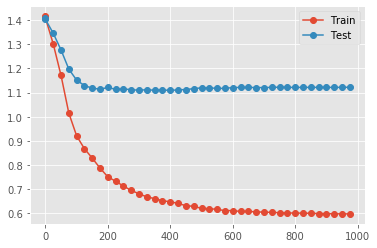

In [ ]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate})

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# scheduler = None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

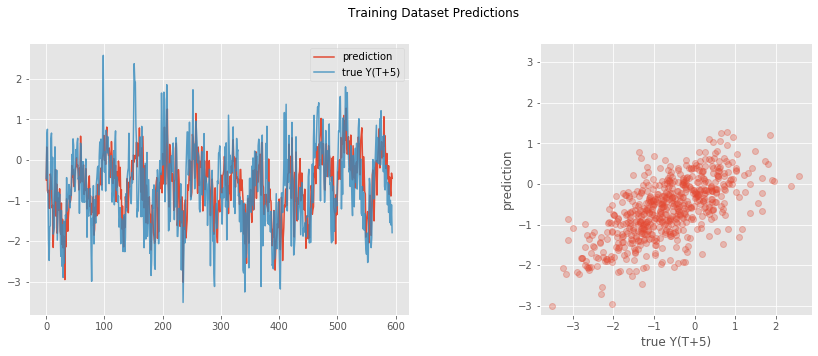

In [ ]:
net.eval()
pred = net(x,Y0).detach().numpy()
target = y.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

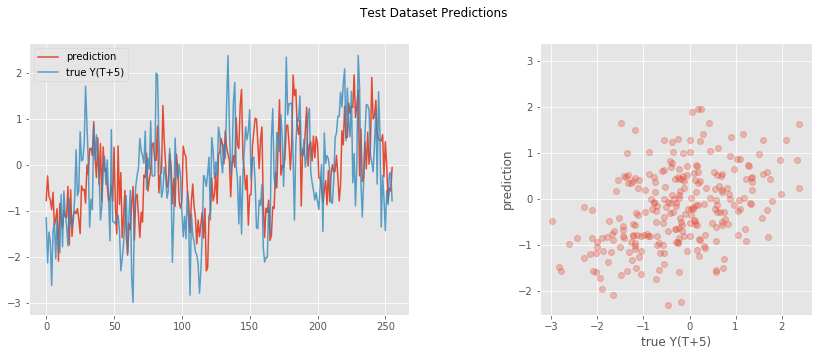

In [ ]:
net.eval()
pred_test = net(x_test,Y0_test).detach().numpy()
target_test = y_test.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

Train lag peak:5
Test lag peak:5


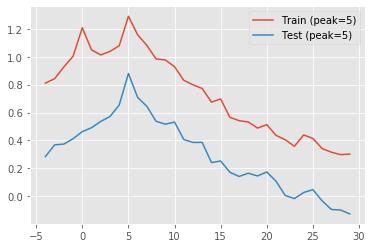

In [ ]:
from src.utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().numpy().ravel(), 
                                        y.numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().numpy().ravel(),
                                      y_test.numpy().ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

plt.legend();
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')